<a href="https://colab.research.google.com/github/darisoy/EE596_Project/blob/main/GAN_room_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple GAN for Creating Furnished Rooms

This code implements a simple Deep Convolutional GAN for creating furnished rooms. And uses a custom dataset for training

## Setup
furnished_dataset is created

In [ ]:
# import data
!git clone https://github.com/darisoy/EE596_Project.git

Cloning into 'EE596_Project'...
remote: Enumerating objects: 3914, done.
remote: Counting objects: 100% (3914/3914), done.
remote: Compressing objects: 100% (3910/3910), done.
remote: Total 3914 (delta 18), reused 3872 (delta 2), pack-reused 0
Receiving objects: 100% (3914/3914), 60.73 MiB | 30.08 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
# add new directory

In [ ]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [ ]:
# Define Image Transformation
im_size = 300
transform = transforms.Compose([transforms.Resize((im_size, im_size)),
                                 transforms.ToTensor()]) 
full_dataset = datasets.ImageFolder('EE596_Project/data/', transform=transform)

# Get only furnished images
furnished_idxs = []
for k, data in enumerate(full_dataset.imgs):
  if data[1] == 1:
    furnished_idxs.append(k)

furnished_dataset = Subset(full_dataset, furnished_idxs)

## GAN Helper Functions

In [ ]:
# Helper functions
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    return torch.FloatTensor(batch_size, dim).uniform_(-1, 1)

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    N, _ = logits_real.size() 
    loss = (bce_loss(logits_real, torch.ones(N).type(dtype)))+(bce_loss(logits_fake, torch.zeros(N).type(dtype)))
    return loss


def generator_loss(logits_fake):
    """
    Computes the generator loss described above.
    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    N, _ = logits_fake.size()
    loss = (bce_loss(logits_fake, torch.ones(N).type(dtype)))
    return loss

def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = optim.Adam(model.parameters(), lr = 1e-3, betas = (0.5,0.999))
    return optimizer

def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = x.type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)
            
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

In [ ]:
def build_dc_classifier():
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
    class View(nn.Module):
      def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

      def forward(self, x):
        return x.view(*self.shape)
    
    
    model = nn.Sequential(
      nn.Conv2d(1,32,5,1),
      nn.LeakyReLU(0.01),
      nn.MaxPool2d(2,2),
      nn.Conv2d(32,64,5,1),
      nn.LeakyReLU(0.01),
      nn.MaxPool2d(2,2),
      View((128,64*4*4)),
      nn.Linear(4*4*64, 4*4*64),
      nn.LeakyReLU(0.01),
      nn.Linear(1024,1)

    )
    return model

data = next(enumerate(loader_train))[-1][0].type(dtype)
print('Input Size:',data.size())
b = build_dc_classifier().type(dtype)
out = b(data)
print('Output Size and Value:', out.size(), out[0].item())

## Define GAN

In [ ]:
def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    class View(nn.Module):
      def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

      def forward(self, x):
        return x.view(*self.shape)

    model = nn.Sequential(
      nn.Linear(96,1024),
      nn.ReLU(inplace=True),
      nn.BatchNorm1d(1024),
      nn.Linear(1024,7*7*128),
      nn.ReLU(inplace=True),
      View((batch_size, 128, 7,7)),
      nn.ConvTranspose2d(128,64,4,2,padding=1),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(64),
      nn.ConvTranspose2d(64,1,4,2,padding=1),
      nn.Tanh(),
      View((batch_size, 28*28))
    )
    return model

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

In [ ]:
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=5)

## Archive

In [ ]:
train_loader = torch.utils.data.DataLoader(furnished_dataset, batch_size=32, shuffle=True)

In [ ]:
for train in train_loader:
  break

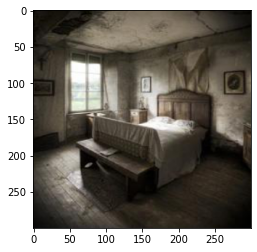

In [ ]:
plt.imshow(train[0][14,:,:,:].permute(1,2,0))

In [ ]:
train[1]

tensor([2, 2, 0, 0, 2, 0, 0, 2, 2, 1, 1, 0, 1, 1, 0, 2, 2, 2, 1, 1, 0, 0, 2, 2,
        2, 2, 0, 0, 1, 1, 0, 1])